In [94]:
import numpy as np
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from scipy.stats import norm, chi2

# Задание 7

#### 1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \left\{(x_1, x_2)\colon \ x_1^2 + x_2^2 \leq 1\right\}$, где 
#### $$f(x_1, x_2) = x_1^3\sin\left(\dfrac{1}{x_1}\right) + 10x_1x_2^4 \cos\left(\dfrac{1}{x_2}\right),$$
#### $f(0, 0) = 0$ по непрерывности.

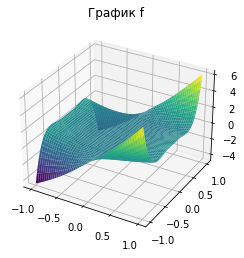

In [96]:
%matplotlib inline
x, y = np.mgrid[-1:1:0.00101, -1:1:0.00101]
z = x**3 * np.sin(1 / x) + 10 * x * y**4 * np.cos(1 / y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')
plt.title('График f')
plt.show()

In [97]:
def opt_fun(x, y):
    return x**3 * np.sin(1 / x) + 10 * x * y**4 * np.cos(1 / y)

Будем генерировать $n$ равномерно распределенных по окружности $A$ независимых случайных величин $X_1, \ldots X_n$ и выбирать в качестве решения ту, на которой минимизируется значение $f$.

Найдем распределение полярных координат при равномерном распределении по окружности:
$$\mathbb{P}(X \in B) = \dfrac{1}{\pi}\iint\limits_Bdxdy = \dfrac{1}{\pi}\iint\limits_Brdrd\varphi = \iint\limits_Bdr^2d\left(\dfrac{\varphi}{2\pi}\right),$$
откуда можно сделать вывод, что $\varphi \sim \mathcal{U}(0, 2\pi)$, а $r$ имеет функцию распределения
$$F_r(x) = 
\begin{cases}
0, &x < 0, \\
x^2, &x \in [0, 1], \\
1, &x > 1.
\end{cases}$$

Для моделирования $r$ будем использовать метод обращения функции распределения:
$$r \overset{d}{=} \sqrt{U}, \quad U \sim \mathcal{U}[0, 1].$$

In [98]:
n = 10**7
loop_sz = 1
fmin = 1
amin = [0, 0]

for i in range(0, loop_sz):
    phi = np.random.rand(n) * 2 * np.pi
    r = np.sqrt(np.random.rand(n))
    f = opt_fun(r * np.cos(phi), r * np.sin(phi))
    cur_min = np.min(f)
    if cur_min < fmin:
        fmin = cur_min
        amin = [r[np.argmin(f)] * np.cos(phi[np.argmin(f)]), r[np.argmin(f)] * np.sin(phi[np.argmin(f)])]
print('min f = ', fmin, '\nargmin f = ', amin)

min f =  -1.2883730598030243 
argmin f =  [-0.3552415993619669, -0.934767668349529]


Оценим точность реализованного метода. Пусть $x^* = \underset{x \in A}{\operatorname{argmax}}  f(x)$. Потребуем, чтобы для найденного решения $x$ выполнялось $|f(x^*) - f(x)| < \varepsilon$ с вероятностью $\alpha$. Так как фунцкция $f$ является непрерывно дифференцируемой в $A$, верна оценка
$$|f(x^*) - f(x)| \leq \|\nabla f(x^*)\| \|x - x^*\| \leq \sup_A \|\nabla f(x)\|\|x - x^*\| \leq \varepsilon$$
при $\|x - x^*\| \leq \delta = \dfrac{\varepsilon}{\sup\limits_A \|\nabla f(x)\|}$.

Оценим величину $\sup\limits_A \|\nabla f(x)\|$.
$$\dfrac{\partial f}{\partial x_1} = 3x_1^2\sin\left(\dfrac{1}{x_1}\right) - x_1\cos\left(\dfrac{1}{x_1}\right) + 10x_2^4\cos\left(\dfrac{1}{x_2}\right),$$
$$\dfrac{\partial f}{\partial x_2} = 40x_1x_2^3 \cos\left(\dfrac{1}{x_2}\right) + 10x_1x_2^2\sin\left(\dfrac{1}{x_2}\right),$$
$$\|\nabla f(x)\| = \sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \leq \sqrt{14^2 + 50^2} \leq 52.$$
Выберем число испытаний так, чтобы хотя бы один элемент выборки оказался в $\delta$-окрестности $x^*$ с вероятностью не менее $\alpha$. Учтем также, что $x^*$ может лежать на границе круга, и при малых $\delta$ окрестность $B_\delta(x^*) \bigcap A$ можно аппроксимировать полуокружностью.

$$\mathbb{P}(X_k \notin B_\delta(x^*), \ \ k = 1, \ldots, n) \leq \left(1 - \dfrac{\delta^2}{2}\right)^n \leq 1 - \alpha,$$
откуда $n = \dfrac{\ln(1 - \alpha)}{\ln\left(1 - \dfrac{\delta^2}{2}\right)}$

Положим $\varepsilon = 0.01, \alpha = 0.99$. Тогда $\delta = \dfrac{0.01}{52}, \ n = 2.5 \cdot 10^8$.
При таких параметрах результат работы метода 
$$f_* \approx -1.2883, \quad x^* = (-0.3598, -0.9330).$$

In [99]:
delta = 0.01 / 52
alpha = 0.99
n = np.log(1 - alpha) / np.log(1 - delta**2 / 2)
print(n)

249047600.84305027


#### 2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$g(x) = (x_1 - 1)^2 + 100(x_2 - x_1^2)^2.$$

In [100]:
def rosenbrock(x, y):
    return (x - 1)**2 + 100 * (y - x**2)**2

Функция Розенброка имеет глобальный минимум в точке $(1, 1)$.

Описание алгоритма.

0. Задаются входные параметры $m, \sigma, t_0$ и начальное значение $(x_0, y_0)$.
1. Генерируется кандидат на следующий шаг $(x_{k+1}, y_{k+1}) \sim (\mathcal{N}(x_k, t_k\sigma^2),\, \mathcal{N}(y_k, t_k\sigma^2))$ и вычиляется приращение функции $\Delta g = g(x_{k+1}, y_{k+1}) - g(x_k, y_k)$.
2. В случае, если $\Delta g < 0$, делается шаг в $(x_{k+1}, y_{k+1})$.
В противном случае переход выполняется с вероятностью $p_k = \dfrac12\exp\left(-\dfrac{\Delta g}{t_k}\right)$.
3. Понижается температура по закону
$$t_{k+1} = t_k m^{\frac{1}{1+0.1|\Delta g|}}.$$
Такое правило позволяет медленнее понижать температуру в случае, когда начальное приближение далеко от решения, и приращения функции велики.

In [101]:
def annealing(func, sigma, k, t0, x0, y0):
    start = time()
    t = t0
    cur_f = func(x0, y0)
    x = x0
    y = y0
    iterations = 0
    steps = 0
    while t > 10**(-5):
        iterations += 1
        x_new = np.random.randn() * sigma * np.sqrt(t) + x
        y_new = np.random.randn() * sigma * np.sqrt(t) + y
        f_new = func(x_new, y_new)
        df = f_new - cur_f
        if df < 0:
            x = x_new
            y = y_new
            cur_f = f_new 
            steps += 1
        else:
            p = np.exp(- df / t) / 2
            #print(p)
            if np.random.rand() < p:
                x = x_new
                y = y_new
                cur_f = f_new 
                steps += 1
        t *= k ** (1 / (1 + 0.1* abs(df)))
        #t *= k
    return [cur_f, x, y, steps / iterations, time() - start, iterations]

In [102]:
sigma = 2.7 
k = 0.995
t0 = 2
x0 = 10
y0 = 5
print(annealing(rosenbrock, sigma, k, t0, x0, y0))

[2.812553420960297e-05, 0.9998685243565901, 0.9992068938725907, 0.008708541782471744, 0.11847329139709473, 10794]


In [103]:
from tqdm import tqdm
from time import time 

test_sz = 1000
x_res = np.zeros(test_sz)
y_res = np.zeros(test_sz)
times = np.zeros(test_sz)
its = np.zeros(test_sz)
freq = np.zeros(test_sz)
for i in tqdm(range(0, test_sz)):
    res = annealing(rosenbrock, sigma, k, t0, 10 * np.random.randn(), 10 * np.random.randn())
    x_res[i] = res[1]
    y_res[i] = res[2]
    times[i] = res[4]
    freq[i] = res[3]
    its[i] = res[5]

100%|██████████| 1000/1000 [01:58<00:00,  8.45it/s]


Так как аналитическая оценка точность алгоритма затруднительна, оценим точность исходя из распределения ошибки $\|x - x^*\|$.

Average time: 0.1197662353515625
Average step frequency: 0.0072519612833211195
Average number of iterations: 10201.5


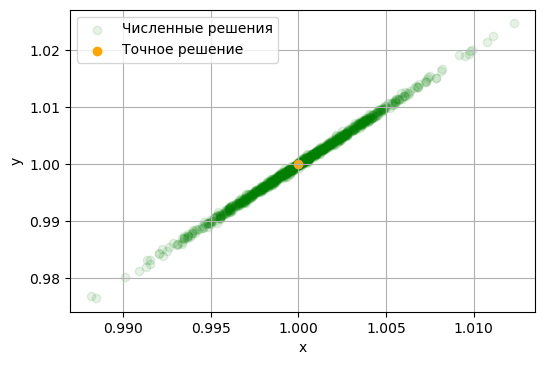

In [106]:
print('Average time:', np.median(times)) # t = 2, sigma = 3, a = 0.995
print('Average step frequency:', freq.mean())
print('Average number of iterations:', np.median(its))
fig, ax = plt.subplots()
fig.dpi = 100

ax.scatter(x_res, y_res, color = 'g', alpha = 0.1, label='Численные решения')
ax.scatter([1], [1], color='orange', label = 'Точное решение')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
plt.show()

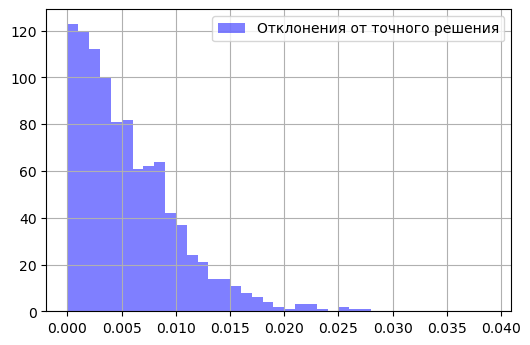

Дисперсия отклонения:  0.0045684048102198485


In [107]:
dist = np.sqrt((x_res - 1)**2 + (y_res - 1)**2)
fig, ax = plt.subplots()
fig.dpi = 100

ax.hist(dist, bins=np.arange(0, 0.04, 0.001), color='b', alpha=0.5, label='Отклонения от точного решения')
ax.grid()
ax.legend()
plt.show()
print('Дисперсия отклонения: ', np.sqrt(dist.var()))

На гистограмме показаны ошибки $\|x - x^*\|$. По выборке размера $n = 1000$ вычислим квантиль порядка $0.99$.

In [108]:
print(np.quantile(dist, 0.99))

0.021226783141055913


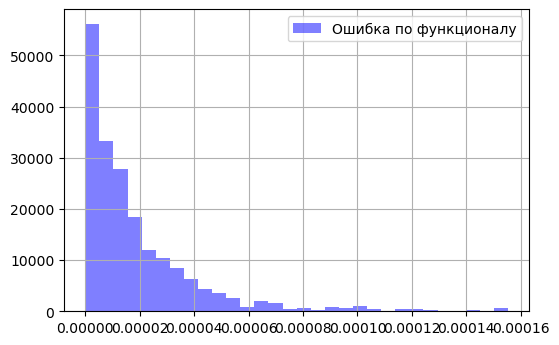

In [109]:
f_res = rosenbrock(x_res, y_res)
fig, ax = plt.subplots()
fig.dpi = 100

ax.hist(f_res, bins=30, density=True, color='b', alpha=0.5, label='Ошибка по функционалу')
ax.grid()
ax.legend()
plt.show()

На гистограмме показано распределение ошибки $\|f(x) - f(x^*)\|$. Квантиль порядка $0.99$ равен

In [110]:
print(np.quantile(f_res, 0.99))

0.00010463612015921


#### 3. Оценить точность. Сравнить результаты со стандартными методами оптимизации.

Проверим результат метода имитации отжига методом сопряженных градиентов.

In [111]:
from scipy.optimize import minimize, rosen
import scipy

x0 = [5, 5]
res = minimize(rosen, x0, method='CG', tol=1e-6)
print(res)

     fun: 2.0087517606575458e-12
     jac: array([4.55523459e-07, 2.83432080e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 236
     nit: 23
    njev: 75
  status: 2
 success: False
       x: array([0.99999858, 0.99999718])


Задачу минимизации из пункта 1 будем решать методом COBYLA (Constrained Optimization BY Linear Approximation).

In [112]:
def opt_fun_1(x):
    return x[0]**3 * np.sin(1 / x[0]) + 10 * x[0] * x[1]**4 * np.cos(1 / x[1])

In [113]:
x0 = [-0.2, -0.8]
cnst = scipy.optimize.NonlinearConstraint(lambda x: (x**2).sum(), 0, 1)
res = minimize(opt_fun_1, x0, method='COBYLA', tol=1e-6, constraints=cnst)
res

     fun: -1.288489227610783
   maxcv: 2.90745205688836e-12
 message: 'Optimization terminated successfully.'
    nfev: 59
  status: 1
 success: True
       x: array([-0.35735285, -0.93396945])

При начальном приближении, далеком от $x^*$, функция возвращает неверный результат.

In [114]:
x0 = [0.2, 0.1]
cnst = scipy.optimize.NonlinearConstraint(lambda x: (x**2).sum(), 0, 1)
res = minimize(opt_fun_1, x0, method='COBYLA', tol=1e-6, constraints=cnst)
res

     fun: -0.012217243593008359
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 49
  status: 1
 success: True
       x: array([ 0.24551919, -0.11102656])

# Задание 8

#### 1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге:
$$
\begin{cases}
\Delta u = 0, \quad (x, y) \in D = \{(x, y)\colon \ \ x^2 + y^2 \leq 1\}\\
u|_{\partial D} = f(x, y) \\
u \in C^2(D), \ f \in C(\partial D)
\end{cases}
$$

#### Для функции $f(x, y) = x^2 - y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

Введем на плоскости сетку $x_{ij} = (-1 + ih, -1 + jh)$ с шагом $h$ и назовем внутренними узлы, для которых все 4 соседних узла лежат в круге. Узлы, лежащие в круге, но не удовлетворяющие этому условию, будем называть крайними. 

Аппроксимируя вторые частные производные, можно свести задачу Дирихле к следующей разностной схеме:
$$u_{ij} = \dfrac14(u_{i-1,j} + u_{i+1, j} + u_{i, j-1} + u_{i,j+1}) \text{ для внутренних узлов},$$
$$u_{ij} = f_{ij} \text{ для крайних узлов}.$$

Рассмотрим теперь следующую модель случайного блуждания: 
1. Частица начинает свой путь во внутреннем узле $x_{ij}$.
2. С равными вероятностями она переходит в один из четырех соседних узлов.
3. Процесс продолжается до тех пор, пока частица не попадет на крайний узел $x_{pq}$.

Обозначим $p(x_{ij}, x_{pq})$ вероятность, начав путь в узле $x_{ij}$, закончить его в узле $x_{pq}$. Из формулы полной вероятности следует
\begin{equation}
p(x_{ij}, x_{pq}) = \dfrac14(p(x_{i-1,j}, x_{pq}) + p(x_{i+1, j}, x_{pq}) + p(x_{i, j-1}, x_{pq}) + p(x_{i,j+1}, x_{pq}))
\end{equation}
для внутренних узлов $x_{ij}$ и $p(x_{ij}, x_{ij}) = 1$ для крайних узлов.

Рассмотрим теперь случайную величину $\xi_{ij} = f(x_{pq})$ - значение $f$ в конечной точке пути.
Так как $\mathbb{E}\xi_{ij} = \sum_{p, q}p(x_{ij}, x_{pq})f(x_{pq})$, используя формулу связи вероятностей на соседних узлах, получим
$$\mathbb{E}\xi_{ij} = \dfrac14(\mathbb{E}\xi_{i-1,j} + \mathbb{E}\xi_{i+1, j} + \mathbb{E}\xi_{i, j-1} + \mathbb{E}\xi_{i,j+1}) \text{ для внутренних узлов,}$$
$$\mathbb{E}\xi_{ij} = f_{ij} \text{ для крайних}.$$

Видно, что эти уравнения совпадают с разностной схемой, аппроксимирующей исходную задачу.

Значения $\mathbb{E}\xi_{ij}$ в каждом узле можно вычислить методом Монте-Карло, моделируя описанный выше случайных процесс.

In [299]:
def dirichlet_monte_carlo(x, y, f, n, h):
    cur_x = x * np.ones(n)
    cur_y = y * np.ones(n)
    idx = (cur_x**2 + cur_y**2 < 1)
    while(any(idx)):
        plt.plot(cur_x[1000], cur_y[1000], '.')
        direc = np.random.randint(2, size = np.sum(idx))
        cur_x[idx] += 2 * h * (np.random.randint(2, size = np.sum(idx)) - 0.5) * direc
        cur_y[idx] += 2 * h * (np.random.randint(2, size = np.sum(idx)) - 0.5) * (1 - direc)           
        idx = (cur_x**2 + cur_y**2 < 1)
    plt.plot(cur_x, cur_y, 'o')
    print(f(cur_x, cur_y))
    return np.mean(f(cur_x, cur_y))

Для оптимизации вычислений воспользуемся тем, что моделируемый случайный процесс обладает марковским свойством: его "будущее" не зависит от "прошлого", поэтому при прохождении траектории через промежуточные узлы дальнейший путь частицы можно рассматривать как процесс, начавшийся в этом промежуточном узле.

In [116]:
def dirichlet_monte_carlo_matrix(X, Y, f, n, h):
    idx = X**2 + Y**2 <= 1
    (nx, ny) = X.shape
    res = np.zeros(X.shape)
    N = np.ones(X.shape) * np.inf
    N[idx] = 0
    passed = np.zeros(X.shape)
    while np.min(N) < n: # пока не пройдем через каждую точку хотя бы n раз
        passed[passed > 0] = 0
        (i, j) = np.unravel_index(N.argmin(), N.shape)
        passed[i][j] += 1
        while 1 - 2 * (i + j) * h + (i**2 + j**2) * h**2 < 0 and i > 0 and j > 0 and i < nx - 1 and j < ny - 1:
            if np.random.randint(2):
                i += int(2 * (np.random.randint(2) - 0.5))
            else:
                j += int(2 * (np.random.randint(2) - 0.5))
            passed[i][j] += 1
        res[passed > 0] += f(X[i][j], Y[i][j]) * passed[passed > 0]
        N[passed > 0] += passed[passed > 0]
    Z = np.ones(X.shape) * np.inf    
    Z[idx] = res[idx] / N[idx]
    return Z

In [300]:
h = 0.05
n = 10**3 # Похожее решение и терпимое время при n = 10**3. 
          # Очень красивое решение и несколько минут ожидания при n = 10**4
X, Y = np.mgrid[-1:1:h, -1:1:h]
f = lambda x, y : x**2 - y**2
Z = dirichlet_monte_carlo_matrix(X, Y, f, n, h)

/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


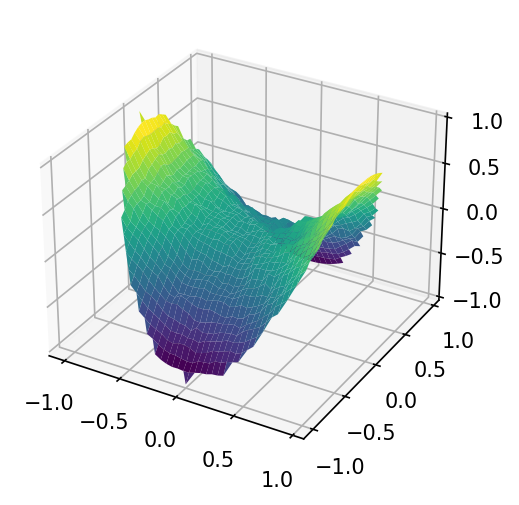

In [301]:
# график численного решения
fig = plt.figure()
fig.dpi = 150

ax = fig.add_subplot(111, projection='3d')
X[Z == np.inf] = np.inf
Z[Z == np.inf] = 0
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

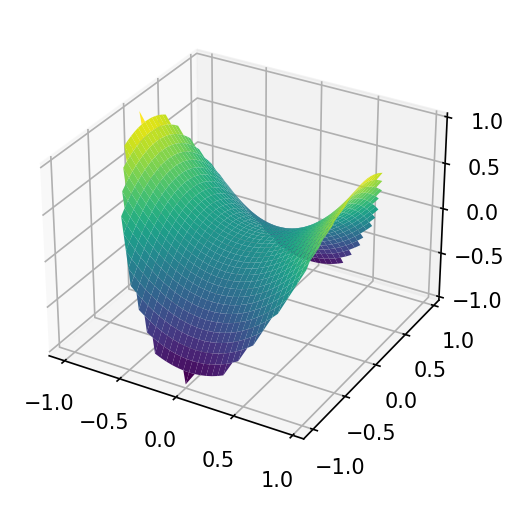

In [302]:
# график аналитического решения
fig = plt.figure()
fig.dpi = 150

ax = fig.add_subplot(111, projection='3d')
h = 0.05
X, Y = np.mgrid[-1:1:h, -1:1:h]
Z_analit = X**2 - Y**2
X[X**2 + Y**2 > 1] = np.inf
ax.plot_surface(X, Y, Z_analit, cmap='viridis')
plt.show()

In [122]:
np.max(np.abs(Z[X**2 + Y**2 <= 1] - Z_analit[X**2 + Y**2 <= 1]))

0.3555532786885245

/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


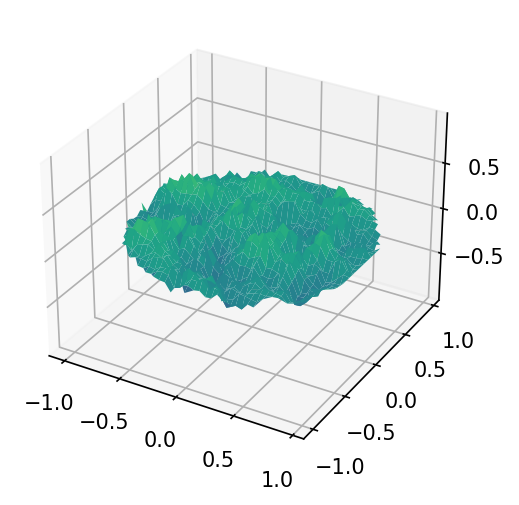

In [123]:
%matplotlib inline
fig = plt.figure()
fig.dpi = 150

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_analit - Z, cmap='viridis')

fig.savefig('/home/mr_giraffe/Documents/StochAn_prac/Report/8_3.pdf', bbox_inches='tight')

# Задание 9

#### Рассмотреть два вида процессов:
- Винеровский процесс $W(t), t \in [0, 1], \ W(0) = 0.$

- Процесс Орнштейна-Уленбека $X(t),\ t \in [0, 1], \ X(0) = X_0$, то есть стационарный марковский гауссовский процесс. Начальное значение $X_0$ генерируется случайным образом так, чтобы полученный процесс бы стационарным.

#### Для данных процессов
1. Найти ковариационную функцию и переходные вероятности.
2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.
3. Построить график траекторий.

Опишем кратко метод добавления разбиения отрезка. Пусть требуется смоделировать случайный процесс $X(t)$ на отрезке $[0, 1]$. 
1. Моделирование $X_0 = X(0)$.
2. Моделирование $X(1)$ по условному распределению $[X(1)|X(0)]$.
3. Между каждыми соседними узлами $t_1, t_2$ сетки добавим узел $t = \dfrac{t_1 + t_2}{2}$ и смоделируем процесс в нем, используя условное распределение случайной величины $[X(t)|X(t_1) = x_1, X(t_2) = x_2]$.
4. Повторение пункта 3 до тех пор, пока шаг сетки не станет достаточно мелким.

#### Винеровский процесс

Винеровский процесс - гауссовский процесс с независимыми приращениями такой, что
- $W(0) \overset{\text{п.н.}}{=} 0$
- $W(t + h) - W(t) \sim \mathcal{N}(0, \sigma^2h)$

Найдем его ковариационную функцию функцию:
$$ R(t_1, t_2) = \mathbb{E}W(t_1)W(t_2) = \{t_1 < t_2\} = \mathbb{E}W^2(t_1) + \mathbb{E}[W(t_1) - W(0)][W(t_2) - W(t_1)] = \sigma^2 t_1 + \mathbb{E}W(t_1)\mathbb{E}[W(t_2) - W(t_1)] = \sigma^2 t_1,$$
откуда
$$K(t_1, t_2) = \min(t_1, t_2) \sigma^2.$$

По определению $W(0) = 0, \ [W(1)|W(0)] \sim \mathcal{N}(0, \sigma^2)$. 

Найдем теперь для $t_1 < t_2 < t_3$ распределение $Y = [W(t_2)|W(t_1) = x_1, W(t_3) = x_3]$. 
Так как $W(t)$ имеет нормальное распределение с параметрами $0$ и $\sigma^2t$, $Y$ имеет плотность
$$p_Y(x_2) = \dfrac{p_{123}(x_1, x_2, x_3)}{p_{13}(x_1, x_3)},$$
где $p_{123}$ -совместная плотность $(W(t_1), W(t_2), W(t_3))$, $p_{13}$ - плотность $(W(t_1), W(t_3))$.

Известно, что плотность $n$-мерного нормального распределения с матожиданием $\mu$ и ковариационной матрицей $\Sigma$ имеет вид
\begin{equation}
p(x) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{-\frac{1}{2} (x - \mu)^T\Sigma^{-1} (x - \mu)\right\}
\end{equation}

Используя полученную для ковариационной функции формулу, получаем
$$
\Sigma_{13} = \sigma^2 \begin{pmatrix} 
t_1 & t_1 \\
t_1 & t_3
\end{pmatrix},
$$
$$
\Sigma_{123} = \sigma^2 \begin{pmatrix}
t_1 & t_1 & t_1 \\
t_1 & t_2 & t_2 \\
t_2 & t_2 & t_3
\end{pmatrix}.
$$

In [124]:
from sympy import symbols, Matrix
import sympy

t1, t2, t3 = symbols('t_1 t_2 t_3', real=True)
x0, x1, x2, x3 = symbols('x_0 x_1 x_2 x_3', real=True)

t2 = (t1 + t3) / 2

S123 = Matrix([[t1, t1, t1], [t1, t2, t2], [t1, t2, t3]])
S13 = Matrix([[t1, t1], [t1, t2]])
x123 = Matrix([[x1], [x2], [x3]])
x13 = Matrix([[x1], [x3]])

p_e = -sympy.Rational(1, 2) * x123.T @ S123.inv() @ x123 + sympy.Rational(1, 2) * x13.T @ S13.inv() @ x13
p_e = p_e[0].simplify()
p_e

(-2*x_1*x_2 + 2*x_1*x_3 + 2*x_2**2 - 2*x_2*x_3)/(t_1 - t_3)

С помощью библиотеки для символьных вычислений sympy найдем
$$p_Y(x_2) = C \exp\left\{ -\dfrac12\dfrac{4}{t_3 - t_1} \left(x_2 - \dfrac{x_1 + x_3}2\right)^2\right\},$$
то есть, обозначая шаг измельченной сетки за $h = t_2 - t_1$, получим $$Y \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{2}, \dfrac{h\sigma^2}{2}\right).$$

#### Процесс Орнштейна-Уленбека

Процесс Орнштейна-Уленбека - это стационарный марковский гауссовский процесс.
Известно, что для такого процесса 
$$\rho(X(t_1), X(t_3)) = \rho(X(t_1), X(t_2))\rho(X(t_2), X(t_3)), \quad t_1 < t_2 < t_3.$$
В силу однородности процесса для любого $t$ верно $X(t) \sim \mathcal{N}(0, \sigma^2)$ (без ограничения общности будем рассматривать центрированный процесс).
Найдем вид функции $K(t) = \rho(X(t), X_0)$, предполагая $0 \leq t_1 < t_2 \leq 1$:
$$ K(t_2) = \rho(X(t_2), X_0) = \rho(X(t_2), X(t_1))\rho(X(t_1), X_0) = K(t_2 - t_1)K(t_1).$$
То есть для любых $t, s$ верно $K(t + s) = K(t)K(s)$. Логарифм этой функции $f(x) = \ln K(x)$ является решением уравнения Коши
$$f(x + y) = f(x) + f(y),$$
и, так как функция $K(t)$ непрерывна и ограничена, она имеет вид
$K(t) = e^{-\lambda t}, \ \lambda > 0$, а ковариационная функция процесса
$$R(t_1, t_2) = \sigma^2 e^{-\lambda |t_2 - t_1|}, \quad \lambda > 0.$$

Сгенерируем $X_0$ как нормальную случайную величину с нулевым матожиданием и дисперсией $\sigma^2$.
Найдем теперь распределение $[X(1)|X_0]$.
Ковариационная матрица для $(X_0, X(1))$ имеет вид 
$$
\Sigma = \sigma^2 \begin{pmatrix} 
1 & e^{-\lambda} \\
e^{-\lambda} & 1
\end{pmatrix}.
$$

In [125]:
lam = sympy.Symbol('lambda')
S = Matrix([[1, sympy.exp(-lam)],
           [sympy.exp(-lam), 1]])
x = Matrix([[x0], [x1]])
p = -sympy.Rational(1, 2) * x.T @ S.inv() @ x
p = p[0].simplify()
sympy.collect(p, x1)

-(x_0*(x_0*exp(lambda) - x_1) + x_1*(-x_0 + x_1*exp(lambda)))/(4*sinh(lambda))

Проведя необходимые расчеты, получаем $$[X(1)|X_0] \sim \mathcal{N}\left(x_0e^{-\lambda}, \sigma^2 (1 -e^{-2\lambda})\right).$$

Найдем теперь распределение $Y = [X(t_2)|X(t_1) = x_1, X(t_3) = x_3],\ t_1 < t_2 < t_3$.

Обозначим шаг новой сетки за $h = t_2 - t_1 = t_3 - t_2$ и, как и в случае винеровского процесса, найдем ковариационные матрицы
$$
\Sigma_{13} = \sigma^2 \begin{pmatrix} 
1 & e^{-2\lambda h} \\
e^{-2 \lambda h} & 1
\end{pmatrix},
$$
$$
\Sigma_{123} = \sigma^2 \begin{pmatrix}
1 & e^{-\lambda h} & e^{-2 \lambda h} \\
e^{-\lambda h} & 1 & e^{-\lambda h} \\
e^{-2\lambda h} & e^{-\lambda h} & 1
\end{pmatrix}.
$$

In [126]:
lam = sympy.Symbol('lambda')
h = sympy.Symbol('h')
S123 = Matrix([[1, sympy.exp(-lam * h), sympy.exp(-2 * lam * h)], 
               [sympy.exp(-lam * h), 1, sympy.exp(-lam * h)],
               [sympy.exp(-2 * lam * h), sympy.exp(-lam * h), 1]])
S13 = Matrix([[1, sympy.exp(-2 * lam * h)], 
              [sympy.exp(-2 * lam * h), 1]])

p_e = -sympy.Rational(1, 2) * x123.T @ S123.inv() @ x123 + sympy.Rational(1, 2) * x13.T @ S13.inv() @ x13
p_e = p_e[0].simplify()
sympy.collect(p_e, x2)

-(x_1**2*exp(2*h*lambda)/2 + x_1*x_3*exp(2*h*lambda) + x_2**2*(exp(4*h*lambda)/2 + exp(2*h*lambda) + 1/2) + x_2*(-x_1*exp(3*h*lambda) - x_1*exp(h*lambda) - x_3*exp(3*h*lambda) - x_3*exp(h*lambda)) + x_3**2*exp(2*h*lambda)/2)/(exp(4*h*lambda) - 1)

In [127]:
b = (sympy.exp(4 * lam * h) - 1) / (sympy.exp(4 * lam * h) + 2 * sympy.exp(2 * lam * h) + 1)
sympy.collect((p_e * (-2 * b)).simplify(), x2)

(x_1**2*exp(2*h*lambda) + 2*x_1*x_3*exp(2*h*lambda) + x_2**2*(exp(4*h*lambda) + 2*exp(2*h*lambda) + 1) + x_2*(-2*x_1*exp(3*h*lambda) - 2*x_1*exp(h*lambda) - 2*x_3*exp(3*h*lambda) - 2*x_3*exp(h*lambda)) + x_3**2*exp(2*h*lambda))/(exp(4*h*lambda) + 2*exp(2*h*lambda) + 1)

После преобразований находим, что $$Y \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{e^{\lambda h} + e^{-\lambda h}},\dfrac{\sigma^2 (e^{2\lambda h} - 1)}{e^{2\lambda h} + 1}\right).$$

In [128]:
def wiener(sigma, k): # моделирует винеровский процесс на сетке размера 2^k + 1
    w = np.zeros(2**k + 1)
    w[-1] = sigma * np.random.randn()
    step = 2**k
    first = 2**(k - 1)
    h = 1
    for i in range(0, k):
        h /= 2
        w[first::step] = np.random.randn(2**i) * np.sqrt(h / 2) * sigma + (w[:-1:step] + w[step::step]) / 2
        first = first // 2
        step = step // 2
    return w

In [129]:
%matplotlib inline

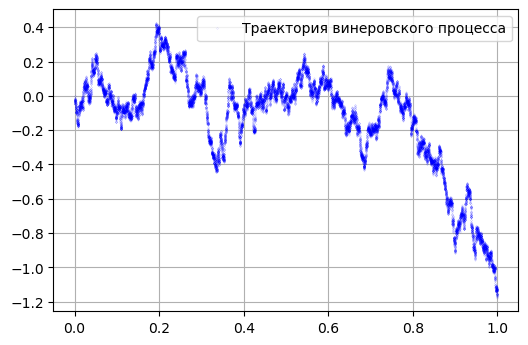

In [130]:
k = 15
sigma = 1
w = wiener(sigma, k)
x = np.linspace(0, 1, 2**k + 1)

fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(x, w, 'b.', ms = 0.1, label='Траектория винеровского процесса')
ax.grid()
ax.legend()
plt.show()

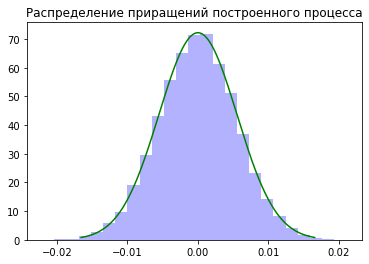

In [131]:
plt.hist(np.diff(w), bins=25, density=True, color='b', alpha=0.3)
h = 1 / 2**k
x = np.linspace(-3 * sigma * np.sqrt(h), 3 * sigma * np.sqrt(h), 2**k)
plt.plot(x, 1 / sigma / np.sqrt(h) * norm.pdf(x / sigma / np.sqrt(h)), c='g', lw=1.5)
plt.title('Распределение приращений построенного процесса')
plt.show()

In [132]:
 def ornstein_uhlenbeck(sigma, lam, k): # моделирует процесс Орнштейна-Уленбека на сетке размера 2^k + 1
    ou = np.zeros(2**k + 1)
    ou[0] = np.random.randn() * sigma
    ou[-1] = sigma * np.sqrt(1 - np.exp(-2 * lam)) * np.random.randn() + ou[0] * np.exp(-lam)
    step = 2**k
    first = 2**(k - 1)
    h = 1
    for i in range(0, k):
        h /= 2
        ou[first::step] = np.random.randn(2**i) * sigma * np.sqrt((np.exp(2 * h * lam) - 1) / (np.exp(2 * h * lam) + 1)) + (ou[:-1:step] + ou[step::step]) / (np.exp(lam * h) + np.exp(-lam * h))
        first = first // 2
        step = step // 2
    return ou

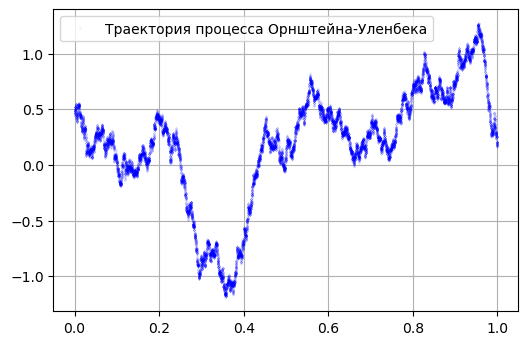

In [133]:
k = 15
sigma = 1
lam = 1
ou = ornstein_uhlenbeck(sigma, lam, k)
x = np.linspace(0, 1, 2**k + 1)
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(x, ou, 'b.', ms=0.1, label='Траектория процесса Орнштейна-Уленбека')
ax.grid()
ax.legend()

# Задание 10

#### Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:
#### 1. Используя генератор белого шума, добавить случайную ошибку с известной дисперсией к реализации процесса Орнштейна-Уленбека.
#### 2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу. Параметры процесса и белого шума считать известными.
#### 3. Рассмотреть случай, когда шум
   - является гауссовским;
   - имеет распределение Коши.

Рассмотрим сетку $\{t_n = nh, n = 0, 1, \ldots, N\},\ h = \dfrac1N$ и значения процесса Орнштейна-Уленбека
$x_n = X(t_n).$

Представим процесс в виде дискретной динамической системы вида
$$x_{n+1} = ax_n + \nu_n, \quad \mathrm{i.i.d.}\ \nu_n \sim \mathcal{N}(0, q), \quad x_1 \sim \mathcal{N}(0, \sigma^2).$$
Обозначим зашумленный сигнал
$$y_n = x_n + \varepsilon_n, \quad \mathrm{i.i.d.}\ \varepsilon_n \sim \mathcal{N}(0, r).$$
Параметры $\sigma, \lambda$ процесса считаем известными. Найдем через них параметры системы $a, q$. Для этого запишем ковариационную функцию для процесса в моменты $t_n$ и $t_{n+1}$:
$$R(t_n, t_n) = \mathrm{var}(x_n) = \sigma^2,$$
$$R(t_n, t_{n+1}) = \mathrm{cov}(x_n, x_{n+1}) = a\ \mathrm{var}(x_n) = a\sigma^2 = \sigma^2 e^{-\lambda h},$$
$$R(t_{n+1}, t_{n+1}) = \mathrm{var}(x_{n+1}) = a^2\mathrm{var}(x_n) + q = a^2\sigma^2 + q = \sigma^2.$$
Отсюда легко выразить
$$a = e^{-\lambda h}, \quad q = \sigma^2(1 - e^{-2\lambda h}).$$

Опишем один шаг дискретного фильра Калмана. Обозначим за $\hat x_{n|n}$ оценку значения $x_n$ при известных $y_1, \ldots y_n$. $\hat x_{n|n-1}$ - экстраполяция процесса на следующий шаг в соответствии с динамической системой. Через $p_{n|n}$ будем обозначать дисперсию ошибки фильтрации на $n$-м шаге, через $p_{n|n-1}$ - прогнозируемую на следующем шаге дисперсию.

1. Прогнозируем значение процесса и дисперсию ошибки
$$ \hat x_{n|n-1} = a\hat x_{n-1|n-1}, \quad p_{n|n-1} = a^2 p_{n-1|n-1} + q.$$
2. Вычисляем разницу между наблюдаемым процессом и прогнозом и коэффициент усиления Калмана
$$ \delta_{n} = y_n - \hat x_{n|n-1}, \quad k_n = \dfrac{p_{n|n-1}}{p_{n|n-1} + r}.$$
3. В качестве результата фильтрации берем выпуклую комбинацию наблюдаемого и предсказанного значения
$$ \hat x_{n|n} = \hat x_{n|n-1} + k_n\delta_n, \quad p_{k|k} = (1 - k_n)p_{n|n-1}. $$

Поскольку рассматривается линейный фильтр гауссовского процесса с гауссовским шумом, ошибка фильтрации будет иметь нормальное распределение, а доверительный интервал с уровнем доверия $\alpha$ будет иметь вид
$$[\hat x_{n|n} - \Delta, \, \hat x_{n|n} + \Delta], \quad \Delta = -\sqrt{p_{n|n}}\Phi^{-1}\left(\dfrac{\alpha}2\right).$$

#### Нормальная ошибка

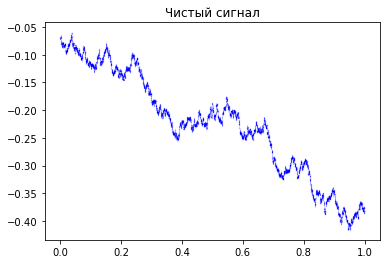

In [134]:
k = 15
n = int(2**k + 1)
sigma = 1
lam = 0.01
x = ornstein_uhlenbeck(sigma, lam, k)
ls = np.linspace(0, 1, n)
plt.plot(ls, x, 'b.', alpha=0.8, ms=0.05)
plt.title('Чистый сигнал')
plt.show()

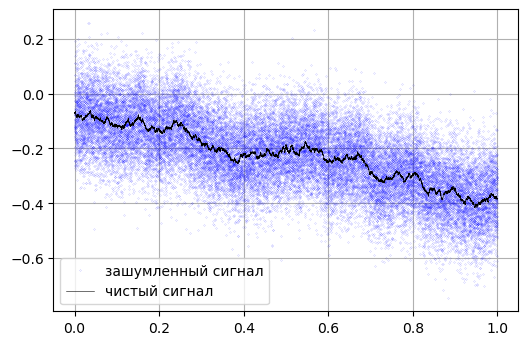

In [135]:
r = 0.01
noise = np.sqrt(r) * np.random.randn(n)
y = x + noise
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(ls, y, 'b.', alpha=1, ms = 0.15,label='зашумленный сигнал')
ax.plot(ls, x, 'k', lw=0.4, label='чистый сигнал')
ax.legend()
ax.grid()
plt.show()

In [136]:
def kalman(y, a, q, r):
    n = y.size
    p = np.zeros(n)
    x_est = np.zeros(n)
    x_est[0] = y[0]
    p[0] = r
    for i in range(1, n):
        x_pred = a * x_est[i - 1]
        p_pred = a**2 * p[i - 1] + q
        dif = y[i] - x_pred
        k = p_pred / (p_pred + r)
        x_est[i] = x_pred + k * dif
        p[i] = (1 - k) * p_pred
    return [x_est, p]

In [137]:
h = 1 / (n - 1)
a = np.exp(-lam * h)
q = sigma**2 * (1 - np.exp(-2 * lam * h))

[filtered, err] = kalman(y, a, q, r) 

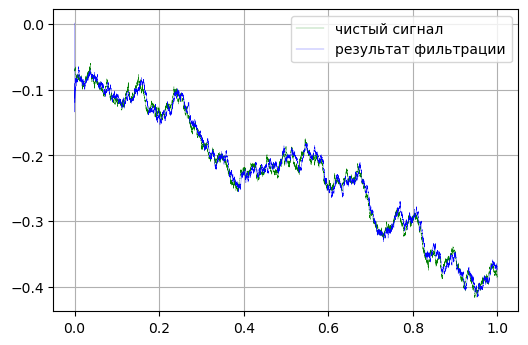

In [138]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(ls, x, 'g-', lw = 0.2, ms = 0.07, label='чистый сигнал')
ax.plot(ls, filtered, 'b-', lw=0.2, ms = 0.07, label='результат фильтрации')
ax.legend()
ax.grid()
plt.show()

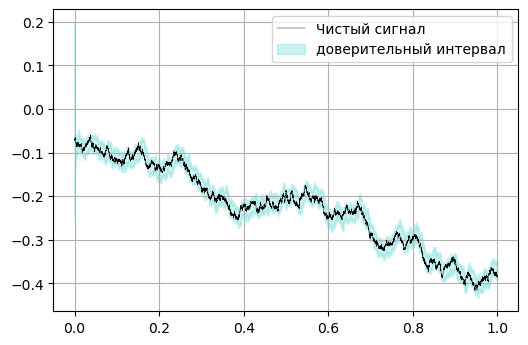

Out of the confidence interval: 4.391345478958772 %


In [139]:
alpha = 0.05
gamma = norm.ppf(alpha / 2)
one_side_error = -np.sqrt(err) * gamma

left = filtered - one_side_error
right = filtered + one_side_error

fig, ax = plt.subplots()
fig.dpi = 100

ax.fill_between(ls, left, right, alpha=0.2, color='c', label='доверительный интервал')
ax.plot(ls, x, 'k', lw=0.3, label='Чистый сигнал')
ax.legend()
ax.grid()
plt.show()

print('Out of the confidence interval:', ((x < left) + (x > right)).sum() / n * 100, '%')

#### Ошибка имеет распределение Коши

Text(0.5, 1.0, 'Сигнал без шума')

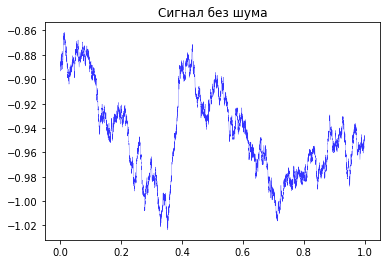

In [140]:
k = 14
n = int(2**k + 1)
sigma = 1
lam = 0.01
x = ornstein_uhlenbeck(sigma, lam, k)
ls = np.linspace(0, 1, n)
plt.plot(ls, x, color='b', alpha=0.8, lw=0.3)
plt.title('Сигнал без шума')

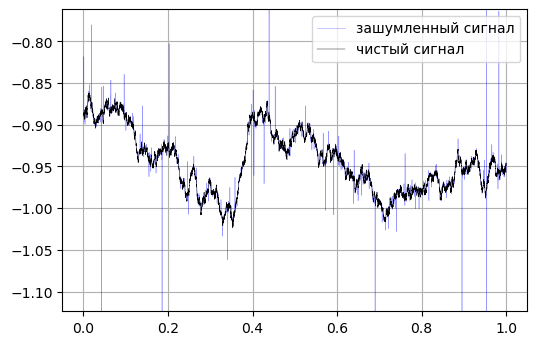

In [141]:
r = 0.0001
noise = np.random.standard_cauchy(n) * r
y = x + noise
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(ls, y, 'b', alpha=0.4, lw=0.4, label='зашумленный сигнал')
ax.plot(ls, x, 'k', lw=0.3, label='чистый сигнал')
ax.set_ylim(np.min(x) - 0.1, np.max(x) + 0.1)
ax.legend()
ax.grid()
plt.show()

In [142]:
h = 1 / (n - 1)
a = np.exp(-lam * h)
q = sigma**2 * (1 - np.exp(-2 * lam * h))

[filtered, err] = kalman(y, a, q, r) 

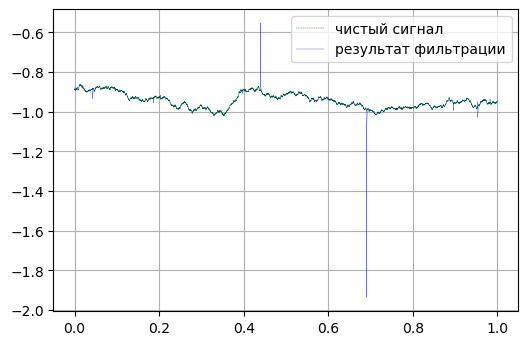

In [143]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(ls, x, 'g--', lw = 0.3, label='чистый сигнал')
ax.plot(ls, filtered, 'b', lw=0.2, label='результат фильтрации')
ax.legend()
ax.grid()
plt.show()

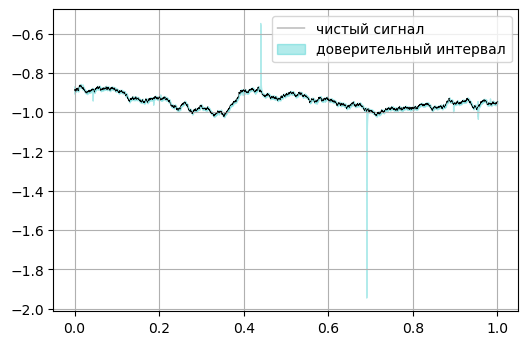

Out of the confidence interval: 1.8858712236801953 %


In [144]:
alpha = 0.05
gamma = norm.ppf(alpha / 2)
one_side_error = -np.sqrt(err) * gamma

left = filtered - one_side_error
right = filtered + one_side_error

fig, ax = plt.subplots()
fig.dpi = 100

ax.fill_between(ls, left, right, alpha=0.3, color='c', label='доверительный интервал')
ax.plot(ls, x, 'k', lw=0.3, label='чистый сигнал')
ax.legend()
ax.grid()
plt.show()
print('Out of the confidence interval:', ((x < left) + (x > right)).sum() / n * 100, '%')

# Задание 11

#### Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:
1. Первая интерпретация: система массового обслуживания. При этом, первая координата поля - время поступления заявки в СМО (равномерное распределение), вторая - время ее обслуживания (распределение $\chi^2$ с 10 степенями свободы).
2. Вторая интерпретация: система массового обслуживания с циклической активностью $\lambda(1 + \cos(t))$ и единичными скачками. Свести данную задачу при помощи метода Льюиса и Шадлеара к моделированию двумерного пуассоновского поля, где первая координата имеет равномерное распределение, а вторая - распределение Бернулли.
3. Третья интерпретация: работа страховой компании. Первая координата - момент наступления страхового случая (равномерное распределение), вторая координата - величина ущерба (распределение Парето). Поступление капитала по времени линейно со скоростью $c > 0$, начальный капитал $W > 0$.
4. Для каждой системы рассмотреть все возможные случаи поведения системы в зависимости от значения параметров.

In [145]:
def chi2_rnd(n, *size): # simulate chi2 distribution with n degrees of freedom
    return (np.random.randn(n, *size)**2).sum(axis=0)

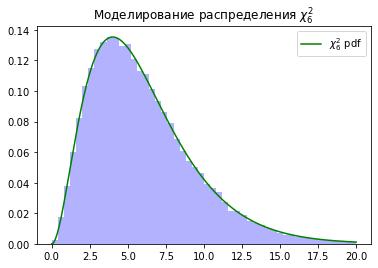

In [146]:
plt.hist(chi2_rnd(6, 10**5), bins=50, density=True, range=(0, 20), color='b', alpha=0.3)
x = np.linspace(0, 20, 1000)
plt.plot(x, chi2.pdf(x, 6), 'g', label=r'$\chi_6^2$ pdf')
plt.title(r'Моделирование распределения $\chi_6^2$')
plt.legend()
plt.show()

### Моделирование СМО

Будем моделировать систему массового обслуживания на отрезке времени $[0, T]$. Обозначим $\eta \sim Pois(\lambda T)$ число заявок, поступивших в систему за время от $0$ до $T$. $\lambda$ - интенсивность поступления заявок, то есть среднее число новых заявок в единицу времени.

Пусть $t_1, \ldots, t_\eta$ - времена поступления заявок, $t_j \sim \mathcal{U}[0, T],\ $ $t_{(j)}$ - $j$-я порядковая статистика, $s_j \sim \chi^2(10)$ - время обработки $j$-й заявки (то есть заявки, поступившей в момент $t_{(j)}$.

Обозначим $X_j$ время окончания обработки $j$-й заявки. Заметим, что
$$X_1 = t_{(1)} + s_1, \quad 
X_j = \begin{cases}
t_{(j)} + s_j, & X_{j - 1} \leq t_{(j)} \\
X_{j-1} + s_j, & X_{j - 1} > t_{(j)}
\end{cases}
$$

Таким образом, число заявок в очереди в момент времени $t$ можно выразить следующим образом:
$$N(t) = \sum_{j=1}^{\eta}\mathbb{1}_{t_{(j)} \leq t < X_j},$$
то есть как число заявок, которые уже поступили к моменту $t$, но еще не были обработаны.

Будем моделировать $\eta \sim Pois(\lambda T)$, затем $t_1, \ldots, t_\eta \sim \mathcal{U}[0, 1],\ s_1, \ldots, s_\eta \sim \chi^2(10)$ как независимые случайные величины. Затем на основе полученной выборки вычисляются $X_1, \ldots, X_\eta$ и $N(t)$.

Заметим также, что время между заявками имеет экспоненциальное распределение с параметром $\lambda$, то есть среднее время между заявками равно $\dfrac{1}{\lambda}$. Среднее время обработки одной заявки равно $\mathbb{E}s_1 = 10$. Таким образом, если $\dfrac{1}{\lambda} < 10$, то есть $\lambda > \dfrac{1}{10}$, то заявки поступают с большей скоростью, чем успевают обрабатываться, и длина очереди неограниченно разрастается.
Если $\lambda < \dfrac{1}{10}$, то скорость обработки превышает скорость поступления. $\lambda = \dfrac{1}{10}$ соответствует некоторому промежуточному состоянию,
при котором скорость поступления заявок совпадает со скоростью их обработки.

In [147]:
def pois_proc(T, lam): # simulates poisson procces. Returns points of the process.
    n = np.random.poisson(lam * T)
    return np.sort(np.random.rand(n) * T)

In [148]:
def pois_proc_fun(tt, t, xi=np.array([])): # returns vector N(tt) for poisson process with points t and jumps xi
    if not xi.size:
        xi = np.ones(tt.size)
    res = np.zeros(tt.size)
    for i in range(0, t.size):
        res += xi[i] * (tt >= t[i])
    return res

In [149]:
def simulate_queue(tt, T, lam, gen_moments): # returns N() and samples t, s, X
    t = gen_moments(T, lam)
    n = t.size
    s = chi2_rnd(10, n)
    x = np.zeros(n)
    x = t + s
    for i in range(1, n):
        if x[i - 1] > t[i]:
            x[i] = x[i - 1] + s[i]
    N = np.zeros(tt.size)
    for i in range(0, n):
        N += (tt > t[i]) * (tt < x[i])
    return (N, t, s, x)

In [150]:
T = 100
lam = 0.2 # 0.1, 0.05, 0.2
n = 1000
tt = np.linspace(0, T, n)
N, t, s, x = simulate_queue(tt, T, lam, pois_proc)

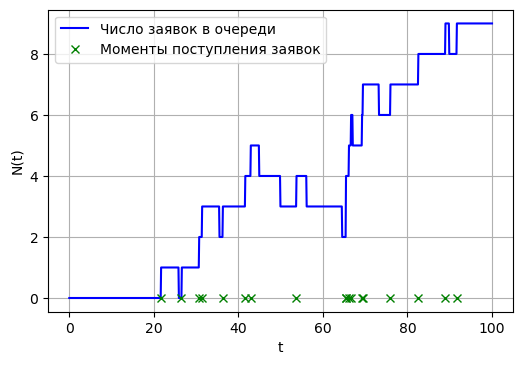

In [151]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(tt, N, 'b', label='Число заявок в очереди')
ax.plot(t, np.zeros(t.size), 'xg', label='Моменты поступления заявок')
ax.grid()
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

### Моделирование СМО с циклической активностью

Для моделировния СМО с циклической интенсивностью $\lambda(t) = \lambda(1 + \cos(t))$ будем использовать метод Льюиса и Шедлеара. Так как $\lambda(t) \leq 2\lambda = \lambda^*$ для любых $t$, будем использовать однородный пуассоновский процесс с интенсивностью $\lambda^*$. Опишем алгоритм моделирования.

1. Генерируем $\eta \sim Pois(\lambda^*)$ и $t_1^*, \ldots, t_\eta^* \sim \mathcal{U}[0, T]$ - времена поступления заявок в процессе $N^*(\cdot)$.
2. Для каждого $j$ удаляем $t_j^*$ из выборки с вероятностью $1 - \dfrac{\lambda(t_j^*)}{\lambda^*(t_j^*)}$.
3. Оставшиеся точки являются моментами поступления заявки в процессе $N(\cdot)$.

Так как средняя мгновенная интенсивность процесса равна $\lambda$, сценарии функционирования СМО абсолютно аналогичны пункту 1.

In [153]:
def nonhom_pois_proc(T, lam, lam_maj=2): # returns points of nonhomogeneous poisson process with intensity lam
    n = np.random.poisson(lam_maj * T)
    t = np.sort(np.random.rand(n) * T)
    idx = np.random.rand(n) < lam(t) / lam_maj
    return t[idx]

In [163]:
T = 4 * np.pi
lam = 10
lamb = lambda t : lam * (1 + np.cos(t))
tt = np.linspace(0, T, 1000)
N, t, s, x = simulate_queue(tt, T, lamb, nonhom_pois_proc)

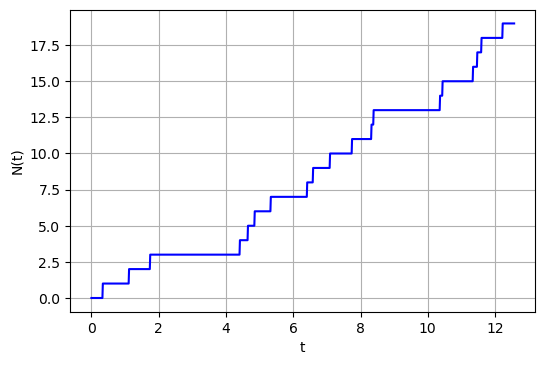

In [164]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(tt, pois_proc_fun(tt, t), 'b')
ax.grid()
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

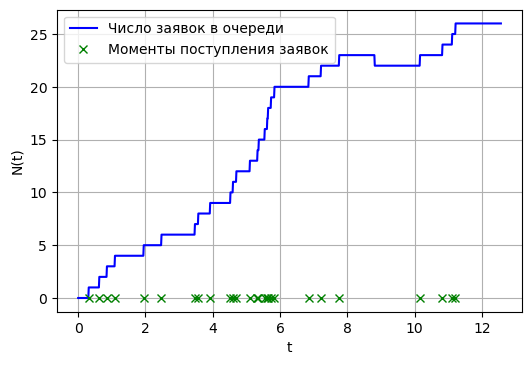

In [156]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(tt, N, 'b', label='Число заявок в очереди')
ax.plot(t, np.zeros(t.size), 'xg', label='Моменты поступления заявок')
ax.grid()
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

### Моделирование работы страховой компании

Пусть число страховых случаев к моменту $t$ равно $N(t)$ - однородный пуассоновский процесс с интенсивностью $\lambda$. Тогда капитал страховой компании изменяется по закону
$$K(t) = W + ct - \sum_{k=1}^{N(t)}\xi_k,$$
где $\xi_k$ имеет распределение Парето с плотностью $p_\xi(x) = \dfrac{k}{x^{k+1}}, \ x > 1$. Параметр распределения Парето $k > 0$.

Если в какой-то момент $\tau$ капитал $K(\tau)$ становится меньше нуля, то $K(t) = 0, \ t > \tau$.

Алгоритм моделирования аналогичен предыдущим пунктам: генерируется $\eta \sim Pois(\lambda T)$,
$t_1, \ldots, t_\eta \sim \mathcal{U}[0, T]$. Случайные величины $\xi_1, \ldots, \xi_\eta$, имеющие распределение Паретор с параметром $k$, будем моделировать методом обращения функции распределения:
$$\xi_j = (1 - U_j)^{-\frac{1}{k}}, \quad U_j \sim \mathcal{U}[0, 1].$$
Далее по вышеописанным формулам вычисляется капитал $K(t)$.

При $k > 1$ распределение Парето имеет математическое ожидание, равное $\dfrac{k}{k-1}$. Тогда легко показать, что 
$$\mathbb{E}K(t) = W + ct - \lambda t \dfrac{k}{k-1},$$
то есть при $c - \dfrac{\lambda k}{k-1} > 0$ капитал компании в среднем будет расти. При противоположном неравенстве K(t) в среднем будет убывать, приводя к разорению. 

При $k \leq 1$ математическое ожидание $\xi_j$ равно бесконечности, и компания рано или поздно будет разоряться при любых значениях $c, W, \lambda > 0$.

In [157]:
def simulate_insur_com(tt, T, lam, k, w, c): # returns vector K(tt)
    t = pois_proc(T, lam)
    n = t.size
    xi = (1 - np.random.rand(n))**(-1 / k)
    K = w + c * tt - pois_proc_fun(tt, t, xi)
    idx = np.nonzero(K < 0)[0]
    if idx.size:
        K[idx[0]:] = 0
    return K

In [158]:
T = 100
lam = 0.9 #1, 1.1, 0.9
k = 2
w = 30
c = 2
tt = np.linspace(0, T, 1000)

cap = simulate_insur_com(tt, T, lam, k, w, c)

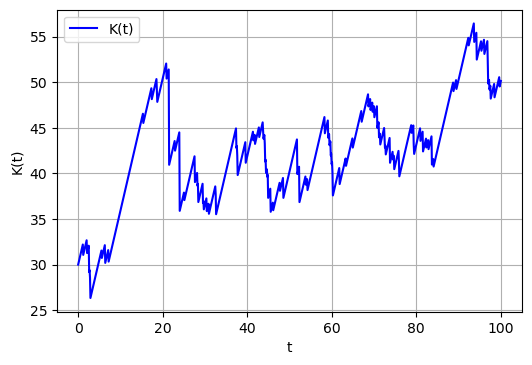

In [159]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(tt, cap, 'b', label='K(t)')
ax.grid()
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('K(t)')
plt.show()

In [160]:
T = 100 # тяжелый хвост
lam = 1
k = 1
w = 100
c = 8
tt = np.linspace(0, T, 1000)

cap = simulate_insur_com(tt, T, lam, k, w, c)

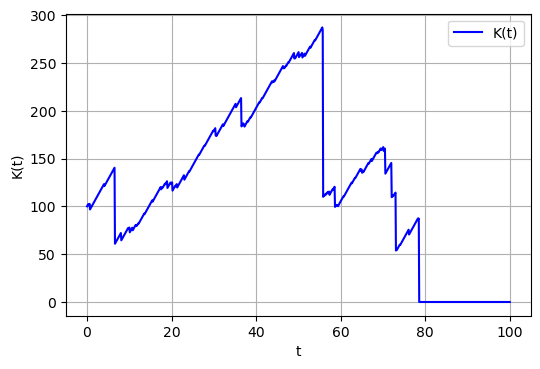

In [161]:
fig, ax = plt.subplots()
fig.dpi = 100

ax.plot(tt, cap, 'b', label='K(t)')
ax.grid()
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('K(t)')
plt.show()